<a href="https://colab.research.google.com/github/AmanPriyanshu/DP-HyperparamTuning/blob/main/RL_DP_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo for RL-DP-Project:

## SET-UP

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!git clone https://github.com/AmanPriyanshu/DP-HyperparamTuning.git ./RL_DP_Project

Cloning into './RL_DP_Project'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 98 (delta 36), reused 48 (delta 12), pack-reused 0
Unpacking objects: 100% (98/98), done.


## Importing Everything:

In [ ]:
!pip install opacus

     |████████████████████████████████| 114 kB 5.2 MB/s 


In [ ]:
from opacus import PrivacyEngine
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import random
import os
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings("ignore")

## Reading the Data:

In [ ]:
class ClassificationDataset(torch.utils.data.Dataset):
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __len__(self):
		return len(self.x)

	def __getitem__(self, idx):
		return torch.from_numpy(self.x[idx].astype(np.float32)), torch.from_numpy(np.array([self.y[idx]]).astype(np.float32))

In [ ]:
def load_sklearn(val_split=0.2):
	x, y = make_classification(n_samples=4000, n_features=8, n_informative=2, n_redundant=2, n_classes=2, n_clusters_per_class=2, flip_y=0.15, class_sep=1.5, hypercube=True, shift=0.0, shuffle=True, random_state=0)
	train_x, train_y, test_x, test_y = x[:int((1-val_split)*len(x))], y[:int((1-val_split)*len(x))], x[int((1-val_split)*len(x)):], y[int((1-val_split)*len(x)):]
	return train_x, train_y, test_x, test_y

In [ ]:
def load_dataset():
	train_x, train_y, test_x, test_y = load_sklearn()
	train_dataset = ClassificationDataset(train_x, train_y)
	test_dataset = ClassificationDataset(test_x, test_y)
	return train_dataset, test_dataset

In [ ]:
train_dataset, test_dataset = load_dataset()
print("Training:", type(train_dataset), "Size:", len(train_dataset))
print("Testing:", type(test_dataset), "Size:", len(test_dataset))

Training: <class '__main__.ClassificationDataset'> Size: 3200
Testing: <class '__main__.ClassificationDataset'> Size: 800


## Creating a Torch-Model

In [ ]:
def get_model():
	model = torch.nn.Sequential(
			torch.nn.Linear(8, 4),
			torch.nn.ReLU(),
			torch.nn.Linear(4, 1),
			torch.nn.Sigmoid(),
		)
	return model

In [ ]:
print(get_model())

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


## Loading our Algorithms:

In [ ]:
from RL_DP_Project.experiment.train_single_model import Experiment
from RL_DP_Project.algorithms.bayesian_optimization import Bayesian
from RL_DP_Project.algorithms.grid_search_algorithm import GridSearch
from RL_DP_Project.algorithms.evolutionary_optimization import EvolutionaryOptimization
from RL_DP_Project.algorithms.reinforcement_learning_optimization import RLOptimization

## Running A DP-Experiment

In [ ]:
def run_sample():
	criterion = torch.nn.BCELoss()
	train_dataset, test_dataset = load_dataset()
	e = Experiment(get_model, criterion, train_dataset, test_dataset)
	results = e.run_experiment(1, 0.001)
	print()
	print("RESULTS:")
	_ = [print(key+":", round(item, 4)) for key, item in results.items()]

In [ ]:
run_sample()

{'type': 'training', 'epoch': 1, 'loss': 0.6896, 'acc': 0.5613}: 100%|██████████| 400/400 [00:04<00:00, 85.53it/s]
{'type': 'testing', 'epoch': 1, 'loss': 0.6919, 'acc': 0.5563}: 100%|██████████| 100/100 [00:00<00:00, 222.54it/s]
{'type': 'training', 'epoch': 2, 'loss': 0.6751, 'acc': 0.5875}: 100%|██████████| 400/400 [00:04<00:00, 84.02it/s]
{'type': 'testing', 'epoch': 2, 'loss': 0.6777, 'acc': 0.58}: 100%|██████████| 100/100 [00:00<00:00, 152.66it/s]
{'type': 'training', 'epoch': 3, 'loss': 0.6601, 'acc': 0.6134}: 100%|██████████| 400/400 [00:04<00:00, 91.88it/s] 
{'type': 'testing', 'epoch': 3, 'loss': 0.662, 'acc': 0.595}: 100%|██████████| 100/100 [00:00<00:00, 209.07it/s]
{'type': 'training', 'epoch': 4, 'loss': 0.6432, 'acc': 0.6338}: 100%|██████████| 400/400 [00:04<00:00, 81.62it/s]
{'type': 'testing', 'epoch': 4, 'loss': 0.6439, 'acc': 0.6112}: 100%|██████████| 100/100 [00:00<00:00, 161.76it/s]
{'type': 'training', 'epoch': 5, 'loss': 0.6242, 'acc': 0.6606}: 100%|██████████| 4


RESULTS:
eps: 1.2102
train_loss: 0.3941
val_loss: 0.3854
train_acc: 0.8816
val_acc: 0.8862


## Creating our Reward Function:

In [ ]:
def calculate_reward(eps, train_loss, val_loss, alpha_u=0.5, alpha_p=0.5):
	return alpha_p*np.exp(-(eps)) + alpha_u*np.exp(-(val_loss))

## Creating Functions to Run Optimizers:

In [ ]:
def run_grid_search():
	criterion = torch.nn.BCELoss()
	train_dataset, test_dataset = load_dataset()
	e = Experiment(get_model, criterion, train_dataset, test_dataset)
	gs = GridSearch(e.run_experiment, calculate_reward, 10, search_space_nm=[2, 5], search_space_lr=[0.001, 0.05])
	progress = gs.run()
	return progress[::-1]

In [ ]:
def run_bayesian():
	criterion = torch.nn.BCELoss()
	train_dataset, test_dataset = load_dataset()
	e = Experiment(get_model, criterion, train_dataset, test_dataset)
	b = Bayesian(e.run_experiment, calculate_reward, 100, search_space_nm=[2, 5], search_space_lr=[0.001, 0.05])
	progress = b.run()
	return progress

In [ ]:
def run_evolutionary_optimization():
	criterion = torch.nn.BCELoss()
	train_dataset, test_dataset = load_dataset()
	e = Experiment(get_model, criterion, train_dataset, test_dataset)
	eo = EvolutionaryOptimization(e.run_experiment, calculate_reward, 10, search_space_nm=[2, 5], search_space_lr=[0.001, 0.05])
	progress = eo.run()
	return progress

In [ ]:
def run_reinforcement_learning_optimization():
	criterion = torch.nn.BCELoss()
	train_dataset, test_dataset = load_dataset()
	e = Experiment(get_model, criterion, train_dataset, test_dataset)
	rl = RLOptimization(e.run_experiment, calculate_reward, 10, search_space_nm=[2, 5], search_space_lr=[0.001, 0.05])
	progress = rl.run()
	return progress

## Running Each Optimizer:

In [ ]:
gs_progress = run_grid_search()

100%|██████████| 100/100 [21:42<00:00, 13.02s/it]


In [ ]:
bo_progress = run_bayesian()

100%|██████████| 100/100 [21:03<00:00, 12.63s/it, best loss: 0.2147609112295663]
{'lr': 0.0017940862990946287, 'nm': 4.800096455988798}


In [ ]:
eo_progress = run_evolutionary_optimization()

{'gen_num': 0, 'lr': 0.0206, 'nm': 2.3, 'eps': 0.3326, 'val_loss': 0.4388, 'reward': 0.6809}: 100%|██████████| 10/10 [02:08<00:00, 12.89s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 0, 'reward_mean': 0.6934687832203716, 'reward_max': 0.7575398511773139}


{'gen_num': 1, 'lr': 0.0206, 'nm': 4.1, 'eps': 0.176, 'val_loss': 0.4125, 'reward': 0.7503}: 100%|██████████| 9/9 [01:55<00:00, 12.86s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 1, 'reward_mean': 0.7445561607140635, 'reward_max': 0.7711721586642581}


{'gen_num': 2, 'lr': 0.0353, 'nm': 2.3, 'eps': 0.3326, 'val_loss': 0.4431, 'reward': 0.6796}: 100%|██████████| 9/9 [01:56<00:00, 12.94s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 2, 'reward_mean': 0.7084664903838429, 'reward_max': 0.7687385396624913}


{'gen_num': 3, 'lr': 0.0402, 'nm': 3.8, 'eps': 0.1885, 'val_loss': 0.6649, 'reward': 0.6713}: 100%|██████████| 9/9 [01:58<00:00, 13.16s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 3, 'reward_mean': 0.7227581060440565, 'reward_max': 0.7566606735186716}


{'gen_num': 4, 'lr': 0.0206, 'nm': 2.0, 'eps': 0.3944, 'val_loss': 0.4722, 'reward': 0.6488}: 100%|██████████| 9/9 [01:55<00:00, 12.87s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 4, 'reward_mean': 0.7219940240767189, 'reward_max': 0.762824049763726}


{'gen_num': 5, 'lr': 0.0059, 'nm': 3.8, 'eps': 0.1885, 'val_loss': 0.3795, 'reward': 0.7562}: 100%|██████████| 9/9 [01:57<00:00, 13.10s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 5, 'reward_mean': 0.7435776467061885, 'reward_max': 0.767639519980928}


{'gen_num': 6, 'lr': 0.0304, 'nm': 3.5, 'eps': 0.2047, 'val_loss': 1.1261, 'reward': 0.5696}: 100%|██████████| 9/9 [01:58<00:00, 13.21s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 6, 'reward_mean': 0.7266806992251911, 'reward_max': 0.771222828081519}


{'gen_num': 7, 'lr': 0.0353, 'nm': 4.1, 'eps': 0.176, 'val_loss': 0.8846, 'reward': 0.6258}: 100%|██████████| 9/9 [01:56<00:00, 12.95s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 7, 'reward_mean': 0.7240482672613099, 'reward_max': 0.7710215247587959}


{'gen_num': 8, 'lr': 0.0108, 'nm': 4.4, 'eps': 0.166, 'val_loss': 0.4951, 'reward': 0.7283}: 100%|██████████| 9/9 [01:59<00:00, 13.23s/it]
  0%|          | 0/9 [00:00<?, ?it/s]

{'gen_num': 8, 'reward_mean': 0.7528602811508066, 'reward_max': 0.7694941854403018}


{'gen_num': 9, 'lr': 0.0402, 'nm': 4.4, 'eps': 0.166, 'val_loss': 0.5299, 'reward': 0.7179}: 100%|██████████| 9/9 [02:04<00:00, 13.80s/it]

{'gen_num': 9, 'reward_mean': 0.7406596381352251, 'reward_max': 0.7712858056903273}


In [ ]:
rl_progress = run_reinforcement_learning_optimization()

100%|██████████| 10/10 [02:12<00:00, 13.25s/it]


## Evaluating the Results:

In [ ]:
eo_progress_ext = np.concatenate(eo_progress, 0)
rl_progress_ext = np.concatenate(rl_progress, 0)

In [ ]:
print("Maximum Reward Achieved by Each Algorithm:")
algorithms = [gs_progress, bo_progress, eo_progress_ext, rl_progress_ext]
max_rewards_index = [np.argmax(i.T[-1]) for i in algorithms]
df = np.stack([i[index] for i, index in zip(algorithms, max_rewards_index)])
df = np.concatenate(([['Grid Search', 'Bayesian Optimization', 'Evolutionary Algorithms', 'Reinforcement Learning']], df.T))
max_rewards = pd.DataFrame(df.T)
max_rewards.columns = 'algorithms, nm, lr, eps, train_loss, val_loss, train_acc, val_acc, reward'.split(', ')
max_rewards.set_index("algorithms", inplace = True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(max_rewards)

Maximum Reward Achieved by Each Algorithm:
                                        nm                     lr  \
algorithms                                                          
Grid Search              4.666666666666666                  0.001   
Bayesian Optimization    4.800096455988798  0.0017940862990946287   
Evolutionary Algorithms  4.208333333333333  0.0026333333333333334   
Reinforcement Learning   4.666666666666666                  0.001   

                                         eps           train_loss  \
algorithms                                                          
Grid Search              0.15877983425643916  0.39874432507902385   
Bayesian Optimization    0.15562559348348476   0.3456091733835638   
Evolutionary Algorithms  0.17211126028152388  0.36756317228544505   
Reinforcement Learning   0.15877983425643916  0.38918179236352446   

                                    val_loss  train_acc    val_acc  \
algorithms                                               

In [ ]:
from matplotlib import pyplot as plt

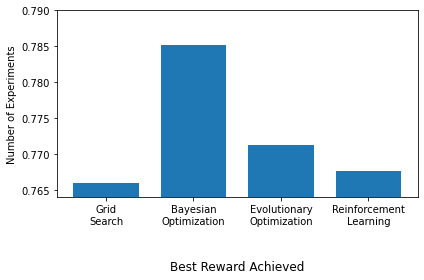

In [ ]:
plt.cla()
plt.bar(np.arange(4), height=[float(i) for i in df[-1]], width=0.75)
plt.ylim([0.764, 0.79])
plt.ylabel("Number of Experiments")
plt.xticks(np.arange(4), ["Grid\nSearch", "Bayesian\nOptimization", "Evolutionary\nOptimization", "Reinforcement\nLearning"])
plt.xlabel('''

Best Reward Achieved''', fontsize=12)
plt.tight_layout()
plt.show()

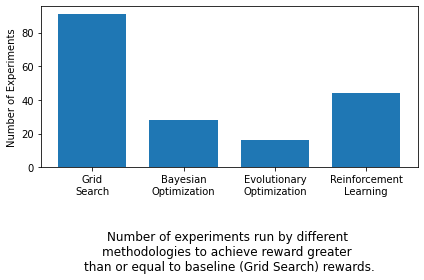

In [ ]:
best_grid_search_reward_index = np.argmax(gs_progress.T[-1])
best_grid_search_reward = gs_progress[best_grid_search_reward_index][-1]

timely_indices = []
for algorithm in algorithms:
  for index, row in enumerate(algorithm):
    if row[-1]>=best_grid_search_reward:
      timely_indices.append(index)
      break

plt.cla()
plt.bar(np.arange(4), height=timely_indices, width=0.75)
plt.ylabel("Number of Experiments")
plt.xticks(np.arange(4), ["Grid\nSearch", "Bayesian\nOptimization", "Evolutionary\nOptimization", "Reinforcement\nLearning"])
plt.xlabel('''

Number of experiments run by different 
methodologies to achieve reward greater 
than or equal to baseline (Grid Search) rewards.''', fontsize=12)
plt.tight_layout()
plt.show()